# Analyzing Dataset Citation Metadata Import and Export by Reference Managers

## Analyze metadata and citation outputs provided by repositories and reference managers for compliance with data citation best practices

This workbook is paired with a paper and dataset analyzing reference manager errors in importing dataset metadata and exporting dataset citations. 

The workbook must be paired with the files in the reference manager dataset to run and then will generate the figures used in the analysis in the paper. The dataset consists of a .txt file for each reference manager's import method. Dataset rows correspond to each dataset DOI analyzed, one for each repository. Dataset columns contain information about the dataset and the imported and exported dataset metadata fields. A 0 indicates correct metadata, a 1 incorrect, and '' or nan missing metadata. 


For more information, contact Kristina Vrouwenvelder or Natalie Raia. 

To cite this software, please use: 

Vrouwenvelder, K. (2024). kvrouwenvelder/reference-manager-analysis: code-for-paper-submission (v1.0). Zenodo. https://doi.org/10.5281/zenodo.14058450


# Import packages

In [662]:
# Import needed packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Functions

In [664]:
# Count correct, missing, incorrect metadata fields for each repository and reference manager 

## Notes
## Returns the input df with 3 added columns for each sum
## Returns an 
## cols is a list of strings of either import or export metadata field column names and defined in variables and definitions
## 'col_type' is a string and used for naming the calculated sum columns (eg _im or _ex) 

def count_fields(input_df,cols,col_type):
    input_df['count_incorrect_'+col_type]=input_df[cols].sum(axis=1, numeric_only=True) # add a column to df with count "incorrect"
    input_df['count_missing_'+col_type]= input_df[cols].isna().sum(axis=1, numeric_only=True) # add a column to df with count 'missing'
    # The count correct is len(cols) - (# incorrect + # missing)
    input_df['count_correct_'+col_type] = len(cols) - (input_df['count_incorrect_'+col_type]+input_df['count_missing_'+col_type])
    return input_df

# Count correct, missing, incorrect across all REFERENCE MANAGERS

## Notes
## Returns an array with the sum for each calculation, for each reference manager
## will sum across all dataframes in list_of_dfs
## cols is a list of strings of either import or export metadata field column names and defined in variables and definitions
## 'col_type' is a string and used for naming the calculated sum columns (eg _im or _ex) 

def sum_across_repos(list_of_dfs, cols, col_type): 
    # list_of_dfs is df names you wish to analyze; cols is list of columns to analyze; col_type is "ex" or "im"
    
    # init full sums
    one_sum = np.zeros(3)
    full_sums = np.tile(one_sum, (len(list_of_dfs), 1))
    for i in range(len(full_sums)):
        full_sums[i] = np.zeros(3)
    

    iter = 0 #start counter
    
    for df in list_of_dfs: # go through list of dfs
        count_fields(df, cols, col_type)
        sum_incorrect = np.sum(df['count_incorrect_' + col_type]) # this will be the first list element in return
        sum_missing = np.sum(df['count_missing_' + col_type]) # This will be the second list element in return
        sum_correct = np.sum(df['count_correct_' + col_type]) #this will be the 3rd list element in return
        sums = [sum_incorrect, sum_missing, sum_correct]
        full_sums[iter] = sums
        iter += 1
    
    return full_sums
    

# Count correct, missing, incorrect across all REPOSITORIES

## Notes
## Returns df with sum across all repositories of correct, incorrect, missing
## will sum across all dataframes in list_of_dfs and add 3 columns to each using count_fields
## cols is a list of strings of either import or export metadata field column names and defined in variables and definitions
## 'col_type' is a string and used for naming the calculated sum columns (eg _im or _ex) 


def sum_across_refmans(list_of_dfs, cols, col_type): 
    # list_of_dfs is df names you wish to analyze; cols is list of columns to analyze; col_type is "ex" or "im"
    
    # init full sums df
    # Number of rows will = # repos in this list
    data = {str('sum_incorrect_'+col_type): np.zeros(len(repo_recommended_citation['Repository'])), #init w zeros
        str('sum_missing_'+col_type): np.zeros(len(repo_recommended_citation['Repository'])),
        str('sum_correct_'+col_type): np.zeros(len(repo_recommended_citation['Repository']))}


    full_sums_df = pd.DataFrame(data) # make empty df 
    full_sums_df['Repository'] = repo_recommended_citation['Repository'] # Add repository name column
    
    for df in list_of_dfs: # go through list of dfs
        count_fields(df, cols, col_type) #returns that dataframe with the 3 sums added
        
        #add sum of each new column to existing dataframe
        full_sums_df['sum_incorrect_'+col_type] += df['count_incorrect_'+col_type]
        full_sums_df['sum_missing_'+col_type] += df['count_missing_'+col_type]
        full_sums_df['sum_correct_'+col_type] += df['count_correct_'+col_type]
    
    return full_sums_df

# Sum across all fields and return incorrect, missing, and correct sums for both import and export by field

## Notes
## Returns a df with sums of each count by field for both import and export for all dfs in list_of_dfs

def sum_across_fields(list_of_dfs): 
    
    #initialize store_data

    data = {'sum_incorrect': np.zeros(24), # set based on # of columns in endnote_plugin
           'sum_missing': np.zeros(24),
           'sum_correct': np.zeros(24)}

    # run for first dataset in list_of_dfs to set correct indices for dataframe:

    data['sum_incorrect'] = list_of_dfs[0].sum(axis=0, numeric_only=True) # sum incorrect
    data['sum_missing'] = list_of_dfs[0].isna().sum(axis=0, numeric_only=True) # sum missing
    data['sum_correct'].fill(len(list_of_dfs)*len(zotero_plugin['Repository'])) # sum correct; fill with total value possible for all fields! 

    # iterate through list of dfs, excluding that first one

    for df in list_of_dfs[1:]:
        data['sum_incorrect'] += df.sum(axis=0, numeric_only=True) # sum incorrect
        data['sum_missing'] += df.isna().sum(axis=0, numeric_only=True) # sum missing

    # Calculate sum_correct as the total possible fields minus incorrect and missing sums
    data['sum_correct'] = data['sum_correct'] - (data['sum_incorrect']+data['sum_missing'])

    # create dataframe
    store_data = pd.DataFrame(data)


    return store_data


# Find the difference in metadata fields exported and imported by reference managers 

## Notes
## Returns a df with total # metadata fields dropped by each reference man across all 8 datasets/repositories
## sums across all dataframes in list_of_dfs
## list_of_dfs can't contain bibtex, bibdesk, crosscite, or repo_recommended_citation

def count_export_import_diff(list_of_dfs, list_of_indices): 

    # init array to store counts for each column of import/export difference array
    store_change_counts = np.zeros(8) # array
    temp_store = np.empty(8)

    for i in list_of_dfs: # run thru all dfs except bibtex, repo_recommended_citation, bib_desk, crosscite

        # convert import and export columns in i to arrays
        import_numpy = i[im_cols].to_numpy(na_value = np.nan)
        export_numpy = i[ex_cols].to_numpy(na_value = np.nan)

        # convert values in export array to make the math easier
        export_numpy[np.isnan(export_numpy)] = 2 # convert nans to 2s
        export_numpy[export_numpy == 0] = np.nan # convert 0s to nans

        # subtract import from export to get a difference array
        change = export_numpy - import_numpy

        # Make a boolean mask of nans in change (array)
        boolarr = np.isnan(change)

        # Create array to store all non-nan values
        for k in range(8):
            temp_store[k] = 14 - boolarr[:,k].sum()

        # add each df non-nan values to dataframe
        store_change_counts = np.vstack([store_change_counts,temp_store])

        print(temp_store)

    # Set columns according to metadata fields
    data_columns = ['Resource Type','Author','Title','Publication Year','DOI','Publisher','Version','Access Date']

    # Set up a dataframe to store results
    store_change_counts = np.delete(store_change_counts, (0), axis=0) # delete first row of this array due to appending causing 15 rows

    change_counts_df = pd.DataFrame(store_change_counts, index = list_of_indices, columns = data_columns)
    
    return change_counts_df

# Data and Variables

## Filepaths and Filenames

In [667]:
# These will be used to import and save files and figures and for naming
filepath = '/Users/kristinavrouwenvelder/Library/CloudStorage/OneDrive-AMERICANGEOPHYSICALUNION/Documents/Data/Reference-Manager-Work/reference-manager-analysis/'
filename = 'reference-manager-data-v3-'
fileext = '.csv' # can use .txt or .csv
filesep = ',' # use '/t' for .txt
reference_manager_filenames = ['BibTeX','repo-recommended-citation','Zotero-plugin','Zotero-wizard','BibDesk','Sciwheel-plugin',
                               'SciWheel-wizard','CrossCite','Endnote-plugin','Endnote-wizard','Papers-plugin','Papers-wizard','Paperpile-plugin',
                               'Paperpile-wizard','Mendeley-plugin','Mendeley-wizard','RefWorks-plugin','Refworks-wizard','Export-options']



## Import Data

In [669]:
# Read data from where it's entered into CSV


# import files
bibtex = pd.read_csv(filepath+filename+reference_manager_filenames[0]+fileext, sep = filesep)
repo_recommended_citation = pd.read_csv(filepath+filename+reference_manager_filenames[1]+fileext, sep = filesep)
zotero_plugin = pd.read_csv(filepath+filename+reference_manager_filenames[2]+fileext, sep = filesep)
zotero_wizard = pd.read_csv(filepath+filename+reference_manager_filenames[3]+fileext, sep = filesep)
bib_desk = pd.read_csv(filepath+filename+reference_manager_filenames[4]+fileext, sep = filesep)
sciwheel_plugin = pd.read_csv(filepath+filename+reference_manager_filenames[5]+fileext, sep = filesep)
sciwheel_wizard = pd.read_csv(filepath+filename+reference_manager_filenames[6]+fileext, sep = filesep)
crosscite = pd.read_csv(filepath+filename+reference_manager_filenames[7]+fileext, sep = filesep)
endnote_plugin = pd.read_csv(filepath+filename+reference_manager_filenames[8]+fileext, sep = filesep)
endnote_wizard = pd.read_csv(filepath+filename+reference_manager_filenames[9]+fileext, sep = filesep)
papers_plugin = pd.read_csv(filepath+filename+reference_manager_filenames[10]+fileext, sep = filesep)
papers_wizard = pd.read_csv(filepath+filename+reference_manager_filenames[11]+fileext, sep = filesep)
paperpile_plugin = pd.read_csv(filepath+filename+reference_manager_filenames[12]+fileext, sep = filesep)
paperpile_wizard = pd.read_csv(filepath+filename+reference_manager_filenames[13]+fileext, sep = filesep)
mendeley_plugin = pd.read_csv(filepath+filename+reference_manager_filenames[14]+fileext, sep = filesep)
mendeley_wizard = pd.read_csv(filepath+filename+reference_manager_filenames[15]+fileext, sep = filesep)
refworks_plugin = pd.read_csv(filepath+filename+reference_manager_filenames[16]+fileext, sep = filesep)
refworks_wizard = pd.read_csv(filepath+filename+reference_manager_filenames[17]+fileext, sep = filesep)
export_options = pd.read_csv(filepath+filename+reference_manager_filenames[18]+fileext, sep = filesep)



## Variables used throughout 

In [671]:
# list all reference managers in df
# list_of_ref_managers = [bibtex,repo_recommended_citation,zotero_plugin,zotero_wizard,bib_desk,sciwheel_plugin,
#                       sciwheel_wizard,crosscite, endnote_plugin, endnote_wizard, papers_plugin,papers_wizard,paperpile_plugin,
#                       paperpile_wizard,mendeley_plugin,mendeley_wizard,refworks_plugin,refworks_wizard]

# Define export metadata fields for count_fields

ex_cols = ['export-meta-type', 'export-meta-authors','export-meta-title','export-meta-date','export-meta-DOI',
            'export-meta-repo','export-meta-version','export-meta-access-date']

# Define import metadata fields for count_fields
im_cols = ['import-meta-type', 'import-meta-authors','import-meta-title','import-meta-date','import-meta-DOI',
            'import-meta-repo','import-meta-version','import-meta-access-date']

# Define list_of_dfs for different use cases

## For graphing fields across repositories, most common errors by metadata field, and comparing import/export accuracy:
## cannot include bibtex, bibdesk, crosscite, or repo_recommended_citation as these are import-only
list_of_dfs = [zotero_plugin,zotero_wizard,sciwheel_plugin,sciwheel_wizard, endnote_plugin, endnote_wizard, 
               papers_plugin,papers_wizard,paperpile_plugin,
                       paperpile_wizard,mendeley_plugin,mendeley_wizard,refworks_plugin,refworks_wizard]


list_of_indices = reference_manager_filenames[2:4]+reference_manager_filenames[5:7]+reference_manager_filenames[8:-1]

## For best repository citation metadata
## does not include bibtex, repo_recommended citation or cross_cite
list_of_dfs_plus_bibdesk = [zotero_plugin,zotero_wizard,bib_desk,sciwheel_plugin,
                       sciwheel_wizard, endnote_plugin, endnote_wizard, papers_plugin,papers_wizard,paperpile_plugin,
                       paperpile_wizard,mendeley_plugin,mendeley_wizard,refworks_plugin,refworks_wizard]


In [672]:
list_of_indices

['Zotero-plugin',
 'Zotero-wizard',
 'Sciwheel-plugin',
 'SciWheel-wizard',
 'Endnote-plugin',
 'Endnote-wizard',
 'Papers-plugin',
 'Papers-wizard',
 'Paperpile-plugin',
 'Paperpile-wizard',
 'Mendeley-plugin',
 'Mendeley-wizard',
 'RefWorks-plugin',
 'Refworks-wizard']

# Accuracy of repository recommended citations
* How many repositories offer a recommended citation? 
* How many repositories offer a recommended citation that is correct when compared to DataCite metadata?
* How many repositories define a citation style? 
* How many repositories offer an opportunity to change the citation style to what journal requires?

In [674]:
filename2 = 'repository-recommended-citation'

# Count the correct , incorrect, missing fields - Export Only
count_fields(repo_recommended_citation, ex_cols,'ex')

# How many repositories specify citation style?
print(str(len(repo_recommended_citation[repo_recommended_citation['Citation-style']=='APA']))+' repositories specify a citation style (APA).')

# Create a stacked bar graph with correct, incorrect, missing fields for each repository

## Sort df by most correct fields
# repo_recommended_citation_sort = repo_recommended_citation.sort_values(['count_correct_ex'], ascending = False)

# ## Start graphing
# ax = repo_recommended_citation.sort_values(['count_correct_ex'], ascending = False).plot.bar(x = 'Repository', y = ['count_correct_ex','count_missing_ex','count_incorrect_ex'], stacked = True, label = ['Correct', 'Missing','Incorrect'],
#                                             color = ['tab:blue','tab:orange','tab:red'])
# plt.ylabel('# Metadata Fields')
# plt.xticks(rotation = 75)
# ax.legend(bbox_to_anchor = (-0.05, 1))


# # need to adjust colors, font sizes, rotation of x labels, graph shape, etc.

# # Save CSV

# repo_recommended_citation.sort_values(['count_correct_ex'], ascending = False).iloc[:,[0,5,6,7,8,9,10,11,12,13,14,15]].to_csv(str(filepath+filename+filename2+'.csv')) # Save CSV of df with graph data

# # Save fig
#  ax.figure.savefig((filepath+filename+filename2+'_vert'+'.png'),dpi=300,bbox_inches='tight')


3 repositories specify a citation style (APA).


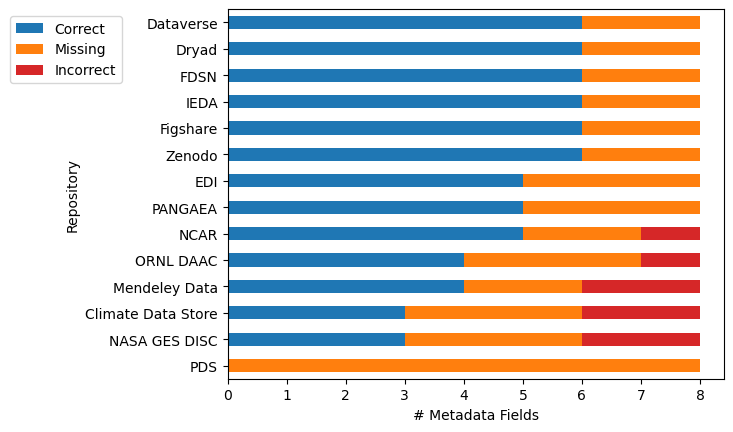

In [675]:
# Horizonal bar graph of repository recommended citation

# Graph
ax = repo_recommended_citation.sort_values(['count_correct_ex'], ascending = True).plot.barh(x = 'Repository', y = ['count_correct_ex','count_missing_ex','count_incorrect_ex'], stacked = True, label = ['Correct', 'Missing','Incorrect'],
                                            color = ['tab:blue','tab:orange','tab:red'])
plt.xlabel('# Metadata Fields')
#ax.legend(loc = 'upper right',framealpha=1)
ax.legend(bbox_to_anchor = (-0.2, 1))

plt.show()

# Save fig
ax.figure.savefig((filepath+filename+filename2+'_horiz'+'.png'),dpi=300,bbox_inches='tight')


# Citation Metadata Accuracy By Reference Manager

* For each reference manager, what are the # of correct fields across all repositories?

NOTE: This can be done for either the import or export fields but is set up here for import only.


In [677]:
# Filename

filename2 = 'correct-fields-all-repos'

# Note
## Must use list_of_dfs that excludes bibtex, repo_recommended_citation, crosscite, bibdesk for import
## list_of_indices is also defined as same

repo_import_sums = sum_across_repos(list_of_dfs, im_cols, 'im')

repo_import_sums_df = pd.DataFrame(data = repo_import_sums, index = list_of_indices, columns = ['sum_incorrect', 'sum_missing', 'sum_correct'])


### Calculate SEM

In [679]:
# Calculate SEM

# need the mean and standard deviation for the correct counts for each reference manager dataframe in list_of_dfs

# init lists to hold values
list_mean_correct = np.zeros(len(list_of_dfs))
list_std_correct = np.zeros(len(list_of_dfs))
iter = 0 #start counter

# iterate across all dataframes (reference managers) to find mean for each reference manager
for df in list_of_dfs:
    list_mean_correct[iter] = np.mean(df['count_correct_im'])
    list_std_correct[iter] = np.std(df['count_correct_im'])
    iter +=1

# append means, stdev, and SEM to repo_import_sums dataframe
repo_import_sums_df['mean_correct'] = list_mean_correct
repo_import_sums_df['std_correct'] = list_std_correct
repo_import_sums_df['sem_correct'] = list_std_correct/np.sqrt(len(list_of_dfs[0]))


# sort by number correct
repo_import_sums_df_sort = repo_import_sums_df.sort_values(by=['sum_correct'],ascending = False)

In [680]:
# # Make graph 

# fig, ax = plt.subplots()
# x = np.arange(len(list_of_dfs)) # of reference managers
# y = 14*8 # Max value possible for repo_export_sums for each ref manager. 14 repos, 8 fields per repo

# # Get xlabels from index and fix them up
# xlabels = repo_import_sums_df.sort_values(by=['sum_correct'],ascending = False).index.str.replace('-',' ') # Use labels from repo_import_sums_df_SORT index and remove hyphen
# xlabels = xlabels.str.replace('wizard','App') # change wizard to App
# xlabels = xlabels.str.replace('plugin','Plugin') # fix capitalization

# ylabels = ['0%','25%','50%','75%','100%']

# offset = 0.25
# width = 0.25

# # to get percentages: df[sum_column]/y*100

# # Graph all
# ax.bar(x - offset, (repo_import_sums_df_sort['sum_correct']/y*100), 
#        width = width, label = 'Correct', color = 'tab:blue')
# ax.bar(x + offset, (repo_import_sums_df_sort['sum_incorrect']/y*100),
#        width = width, label = 'Incorrect', color = 'tab:red')
# ax.bar(x, (repo_import_sums_df_sort['sum_missing']/y*100), 
#        width = width, label = 'Missing', color = 'tab:orange')

# # set labels and ticks and axes
# ax.set_xticks(x,xlabels, rotation = 75) # Either use repo_import_sums_df_sort.index for labels or new string, 'labels'
# ax.set_yticks([0,25,50,75,100],ylabels) # Either [0,y/4,y/2,3*y/4,y] for raw # metadata fields or [0, 25, 50, 100] for %
# ax.set_ylabel('% Total Metadata Fields')
# ax.legend()


# # Save fig

# fig.savefig((filepath+filename+filename2+'_vert'+'.png'),dpi=300,bbox_inches='tight')

# Save CSV

repo_import_sums_df_sort.to_csv(str(filepath+filename+filename2+'.csv')) # Save CSV of df with graph data

### Horizontal - Metadata accuracy by ref man

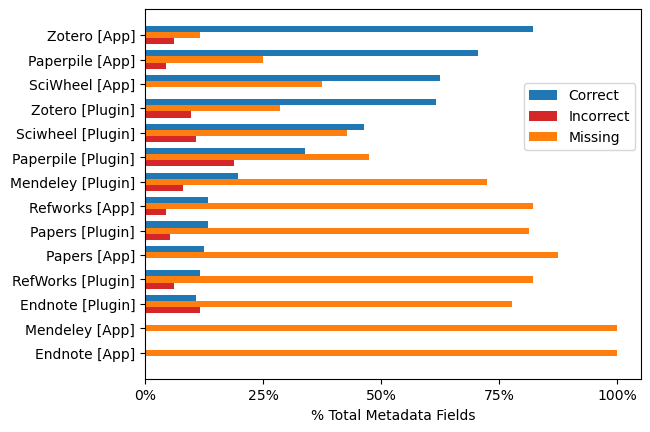

In [682]:
# Horizontal version

# Sort ascending = True to put correct values at top
repo_import_sums_df_sort = repo_import_sums_df.sort_values(by=['sum_correct'],ascending = True)

# Make graph 

fig, ax = plt.subplots()
x = np.arange(len(list_of_dfs)) # of reference managers
y = 14*8 # Max value possible for repo_export_sums for each ref manager. 14 repos, 8 fields per repo

# Get xlabels from index and fix them up
xlabels = repo_import_sums_df_sort.index.str.replace('-',' ') # Use labels from repo_import_sums_df_SORT index and remove hyphen
xlabels = xlabels.str.replace('wizard','[App]') # change wizard to App
xlabels = xlabels.str.replace('plugin','[Plugin]') # fix capitalization

ylabels = ['0%','25%','50%','75%','100%']

offset = 0.25
width = 0.25

# to get percentages: df[sum_column]/y*100

# Graph all
ax.barh(x + offset, (repo_import_sums_df_sort['sum_correct']/y*100), width, label = 'Correct', color = 'tab:blue')
ax.barh(x - offset, (repo_import_sums_df_sort['sum_incorrect']/y*100),width, label = 'Incorrect', color = 'tab:red')
ax.barh(x, (repo_import_sums_df_sort['sum_missing']/y*100), width,label = 'Missing', color = 'tab:orange')

# set labels and ticks and axes
ax.set_yticks(x,xlabels, rotation = 0) # Either use repo_import_sums_df_sort.index for labels or new string, 'labels'
ax.set_xticks([0,25,50,75,100],ylabels) # Either [0,y/4,y/2,3*y/4,y] for raw # metadata fields or [0, 25, 50, 100] for %
ax.set_xlabel('% Total Metadata Fields')
ax.legend(bbox_to_anchor=(0.75, 0.6))

plt.show()

# Save fig

fig.savefig((filepath+filename+filename2+'_horiz'+'.png'),dpi=300,bbox_inches='tight')


## Compare Import and Export Accuracy by Reference Manager

1. Quantify the difference between imports and exports. How much is dropped during export process vs what was already missing during import?
2. Filter import datasets for rows that have 0s. If the zeros changed to either a 1 or NaN in the export dataset, tell us (true/false?). Count all the T/Fs across each metadata field, e.g. ' 'access date was missed 90% of the time'' . (Do we want this for each reference manager or across all reference managers? )

Exclude bibtex, crosscite, bib_desk, repo_recommended_citation

[ 7.  1.  3.  0.  0.  0.  0. 12.]
[ 5.  1.  4.  1.  0.  1.  0. 14.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0.]
[5. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[9. 0. 0. 0. 0. 0. 0. 4.]
[2. 0. 0. 0. 0. 0. 0. 1.]
[0. 1. 1. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[4. 0. 0. 0. 0. 0. 0. 3.]
[4. 0. 0. 0. 0. 0. 0. 0.]


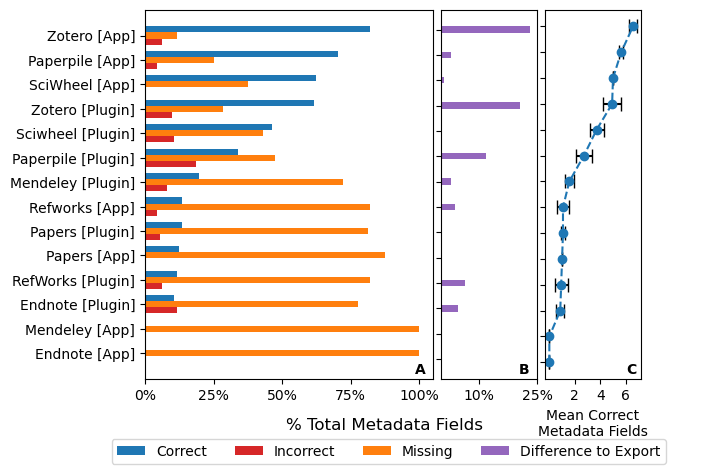

In [684]:
# List_of_dfs and list_of_indices are defined in variables above
## they must exclude bibtex, bibdesk, crosscite, and repo_recommended_citation

# call function to count differences between export and import and return df with differences by metadata field

export_import_diff_counts = count_export_import_diff(list_of_dfs, list_of_indices)

# sum across rows of change_counts_df 
new_hold_arr = export_import_diff_counts.sum(axis=1, numeric_only = True)

# add to repo_import_sums_df in prep for graphing

repo_import_sums_df_sort['sum_export_diff'] = new_hold_arr

# Make graph 

# includes previous results from counting import fields for each reference manager and results of 
# export-import difference

# Get xlabels from index and fix them up
xlabels = repo_import_sums_df_sort.index.str.replace('-',' ') # Use labels from repo_import_sums_df_SORT index and remove hyphen
xlabels = xlabels.str.replace('wizard','[App]') # change wizard to App
xlabels = xlabels.str.replace('plugin','[Plugin]') # fix capitalization

ylabels = ['0%','25%','50%','75%','100%']
ylabels1 = ['10%','25%']

# Graph ONE
x1 = np.arange(len(list_of_dfs)) # of reference managers
y1 = 14*8 # Max value possible for repo_export_sums for each ref manager. 14 repos, 8 fields per repo

# Graph TWO
x2 = np.arange(len(list_of_dfs)) # of reference managers
y2 = 14*8 # Max value possible for repo_export_sums for each ref manager. 14 repos, 8 fields per repo

# Graph THREE
x3 = np.arange(len(list_of_dfs))
y3 = np.arange(len(repo_import_sums_df_sort))

fig, axes = plt.subplots(1, 3, gridspec_kw = {'width_ratios': [3,1,1]})

offset = 0.25
width = 0.25

# Graph ONE
axes[0].barh(x1 + offset, (repo_import_sums_df_sort['sum_correct']/y1*100), width, label = 'Correct', color = 'tab:blue')
axes[0].barh(x1 - offset, (repo_import_sums_df_sort['sum_incorrect']/y1*100),width, label = 'Incorrect', color = 'tab:red')
axes[0].barh(x1, (repo_import_sums_df_sort['sum_missing']/y1*100), width,label = 'Missing', color = 'tab:orange')

# Graph TWO
axes[1].barh(x2, (repo_import_sums_df_sort['sum_export_diff']/y2*100), width, label = 'Difference to Export', color = 'tab:purple')

# Graph THREE
axes[2].errorbar(repo_import_sums_df_sort['mean_correct'], y3, xerr = repo_import_sums_df_sort['sem_correct'], ls='--', marker='o', capsize=5, capthick=1, ecolor='black')

# set legend
lines = []
labels = []

for ax in fig.axes:
    Line, Label = ax.get_legend_handles_labels()
    # print (Label)
    lines.extend(Line)
    labels.extend(Label)
    
# set labels and ticks and axes

# Graph ONE
axes[0].set_yticks(x1,xlabels, rotation = 0) # Either use repo_import_sums_df_sort.index for labels or new string, 'labels'
axes[0].set_xticks([0,25,50,75,100],ylabels) # Either [0,y/4,y/2,3*y/4,y] for raw # metadata fields or [0, 25, 50, 100] for %
#axes[0].set_xlabel('% Total Metadata Fields')
#axes[0].legend(bbox_to_anchor=(0.6, 0.8))
# add subplot label
axes[0].text(0.75, 0.14, 'A', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, weight = 'bold')

# Graph TWO
axes[1].set_yticks(x2,'', rotation = 0) # Either use repo_import_sums_df_sort.index for labels or new string, 'labels'
axes[1].set_xticks([10,25],ylabels1) # Either [0,y/4,y/2,3*y/4,y] for raw # metadata fields or [0, 25, 50, 100] for %
#axes[1].set_xlabel('% Total Metadata Fields')
axes[1].set_xlim(0,25)
#axes[1].legend(bbox_to_anchor = (0.75, 0.75))
# add subplot label
axes[1].text(1.03, 0.14, 'B', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, weight = 'bold')


# Graph THREE
axes[2].set_yticks(y3,'') # Use Repository column
axes[2].set_xticks([2,4,6])
axes[2].set_xlabel('Mean Correct'+ '\n'+ 'Metadata Fields') 
# add subplot label
axes[2].text(1.32, 0.14, 'C', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, weight = 'bold')

# Set figure legend
fig.legend(lines, labels, bbox_to_anchor = (0.95, 0), ncols = 4)

# set figure subtitle
fig.suptitle('% Total Metadata Fields', x = 0.5, y = 0.03)

# set spacing between subplots
plt.subplots_adjust(wspace = 0.05)
plt.show()

fig.savefig((filepath+filename+filename2+'_export_diff'+'.png'), bbox_inches = 'tight')


### Mean correct and SEM - only

Text(0.5, 0, 'Mean Correct Metadata Fields')

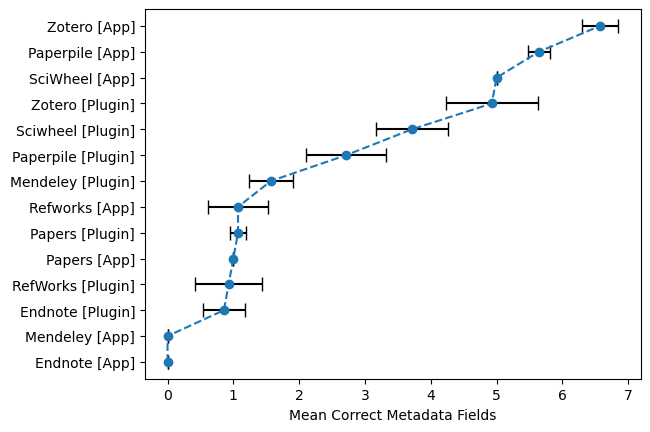

In [686]:
x2 = np.arange(14)
y2 = np.arange(len(repo_import_sums_df_sort))

# sort again to make values show up in descending order
repo_import_sums_df_sort = repo_import_sums_df_sort.sort_values(by=['sum_correct'], ascending = True)

# set x labels
xlabels = repo_import_sums_df_sort.index.str.replace('-',' ') # Use labels from repo_import_sums_df_SORT index and remove hyphen
xlabels = xlabels.str.replace('wizard','[App]') # change wizard to App
xlabels = xlabels.str.replace('plugin','[Plugin]') # fix capitalization

# Graph
fig, ax = plt.subplots()

ax.errorbar(repo_import_sums_df_sort['mean_correct'], y2, xerr = repo_import_sums_df_sort['sem_correct'], ls='--', marker='o', capsize=5, capthick=1, ecolor='black')
ax.set_yticks(y2,xlabels) # Use Repository column
ax.set_xlabel('Mean Correct Metadata Fields')

### Heatmap

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0.5, 1, 'Resource Type'),
  Text(1.5, 1, 'Author'),
  Text(2.5, 1, 'Title'),
  Text(3.5, 1, 'Publication Year'),
  Text(4.5, 1, 'DOI'),
  Text(5.5, 1, 'Publisher'),
  Text(6.5, 1, 'Version'),
  Text(7.5, 1, 'Access Date')])

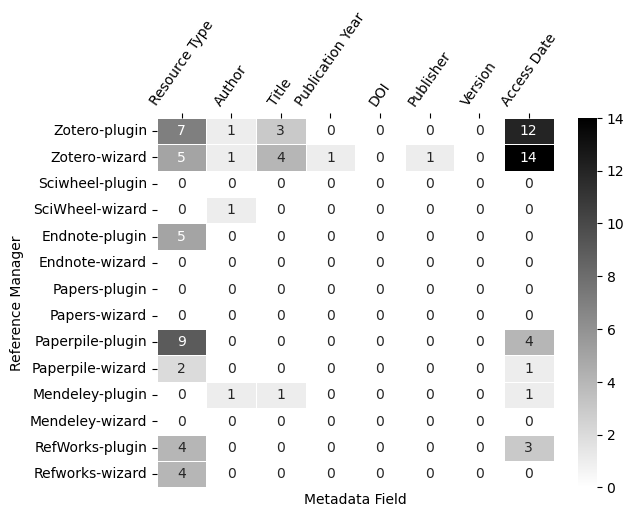

In [688]:
# Create a heatmap from change_counts_df

# This isn't necessary but is an interesting comparison

ax = sns.heatmap(export_import_diff_counts, annot=True, vmin = 0, vmax = 14, cmap = 'binary',linewidth=.5)
ax.set(xlabel="Metadata Field", ylabel="Reference Manager")
ax.xaxis.tick_top()
plt.xticks(rotation=55)

# Existence & Accuracy of Bibtex exports
* How many repositories offer Bibtex exports and in what formats?
* Are Bibtex fields correct? 

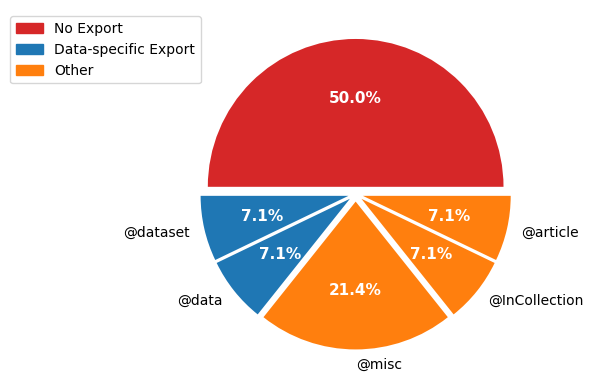

In [690]:
# filename
filename2 = 'bibtex'

# Find how many repos offer Bibtex exports

# Filter by type
bibtex_na = bibtex[bibtex['export-exists'].isna()]
bibtex_dataset = bibtex[bibtex['export-file-type']=='dataset']
bibtex_misc = bibtex[bibtex['export-file-type'].str.contains('misc', na=False)]
bibtex_data = bibtex[bibtex['export-file-type']=='data']
bibtex_incoll = bibtex[bibtex['export-file-type'].str.contains('incollection', na=False)]
bibtex_article = bibtex[bibtex['export-file-type'].str.contains('article', na=False)]

# Graph
# pie chart

labels = ['','@dataset','@data','@misc','@InCollection','@article']
sizes = [len(bibtex_na['export-exists']), len(bibtex_dataset['export-exists']),
         len(bibtex_data['export-exists']),len(bibtex_misc['export-exists']),
         len(bibtex_incoll['export-exists']),len(bibtex_article['export-exists'])]
colors = ['tab:red','tab:blue','tab:blue','tab:orange','tab:orange','tab:orange'] # colors corresp. to correctness

# set explode
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05)

# Plot pie chart
fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, explode = explode, labels=labels, autopct='%1.1f%%', colors = colors)

# set inside label parameters: color, size, weight
# Color = white
for autotext in autotexts: 
    autotext.set_color('white')

# weight and size
plt.setp(autotexts, size=11, weight = 'bold')

# legend
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='tab:red', label='No Export')
blue_patch = mpatches.Patch(color = 'tab:blue', label = 'Data-specific Export')
orange_patch = mpatches.Patch(color = 'tab:orange', label = 'Other')

ax1.legend(handles=[red_patch, blue_patch, orange_patch],bbox_to_anchor = (0.1, 1))
    
# show graph
plt.show()

# Save fig

fig1.savefig((filepath+filename+filename2+'_pie'+'.png'),dpi=300,bbox_inches='tight')



In [691]:
# Filename

filename2 = 'bibtex-fields-by-repo'

# Count the correct , incorrect, missing fields - Import Only
count_fields(bibtex, im_cols,'im')

# Sort fields by correct
# # Graph
# ax2 = bibtex.loc[bibtex['export-exists']==0.0].sort_values(by=['count_correct_im'],ascending = False).plot.bar(
#     x = 'Repository', y = ['count_correct_im','count_missing_im','count_incorrect_im'], 
#                            stacked = True, 
#                            label = ['Correct', 'Missing','Incorrect'],
#                           color = ['tab:blue','tab:orange','tab:red'])
# plt.ylabel('# Metadata Fields')

# # Get x labels
# ax2.legend(loc = 'lower left',framealpha=1)
# ax2.set_xticks(np.arange(7), 
#                labels = bibtex.loc[bibtex['export-exists']==0.0].sort_values(by=['count_correct_im'],ascending = False)['Repository'],
#                rotation=75)

# # Save fig
# plt.show()
# ax2.figure.savefig((filepath+filename+filename2+'_bar'+'.png'),dpi=300,bbox_inches='tight')

# Save CSV

bibtex.loc[bibtex['export-exists']==0.0].sort_values(by=['count_correct_im'],ascending = False).to_csv(str(filepath+filename+filename2+'.csv')) # Save CSV of df with graph data


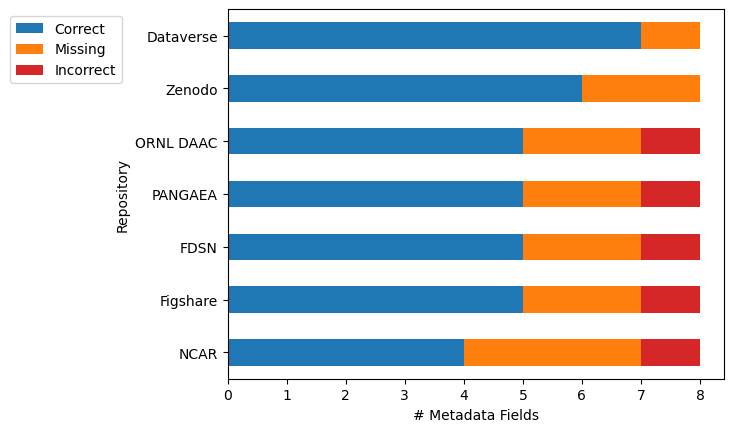

In [692]:
# Horizontal version

# Sort fields (filter by only repos offering bibtex export and sort by # correct)

# Graph
ax2 = bibtex.loc[bibtex['export-exists']==0.0].sort_values(by=['count_correct_im'],ascending = True).plot.barh(
    x = 'Repository', y = ['count_correct_im','count_missing_im','count_incorrect_im'], 
                           stacked = True, 
                           label = ['Correct', 'Missing','Incorrect'],
                          color = ['tab:blue','tab:orange','tab:red'])
plt.xlabel('# Metadata Fields')

# Get x labels
ax2.legend(bbox_to_anchor = (-0.2, 1))

plt.show()

# Save fig

ax2.figure.savefig((filepath+filename+filename2+'_bar_horiz'+'.png'),dpi=300,bbox_inches='tight')


# Citation Metadata Accuracy By Repository

* are there any repositories that are performing exceptionally well across reference managers?


In [694]:
# Filename

filename2 = 'repo-metadata-across-refmans'

# Must exclude bibtex, crosscite, and repo_recommended_Citation for import
# list_of_dfs_plus_bibdesk is defined as such in variables section

# Get repository metadata field sums across reference managers
refman_import_sums = sum_across_refmans(list_of_dfs_plus_bibdesk, im_cols, 'im')

## Calculate standard error in accuracy by repository

Standard error of the mean calculated for quantities represnting populations of data, here, the citation metadata across all reference managers for a single repository dataset. 

- mean = (sum of 'correct' fields)/(number of repositories surveyed, N)
- standard deviation, SD = sqrt((1/N-1)*((x1-xm)^2+...(xn-xm)^2)))
(use ***np.std(x)*** to find SD, where x is the set of values)
- standard error of the mean = SD/sqrt(N)

In [696]:

# init series to store standard deviations
std_correct_by_repo = np.zeros(len(list_of_dfs_plus_bibdesk[0])) #init with zeros, # of repos
std_incorrect_by_repo = np.zeros(len(list_of_dfs_plus_bibdesk[0])) #init with zeros, # of repos
std_missing_by_repo = np.zeros(len(list_of_dfs_plus_bibdesk[0])) #init with zeros, # of repos

mean_correct_by_repo = np.zeros(len(list_of_dfs_plus_bibdesk[0])) #init with zeros, # of repos
mean_incorrect_by_repo = np.zeros(len(list_of_dfs_plus_bibdesk[0])) #init with zeros, # of repos
mean_missing_by_repo = np.zeros(len(list_of_dfs_plus_bibdesk[0])) #init with zeros, # of repos

# go through each repository in the list and each ref man
for repo_row in range(len(list_of_dfs_plus_bibdesk[0])): #iterate through length of one dataframe in list
    # init series to store values for each repo from each ref man
    values_correct_by_repo = np.zeros(len(list_of_dfs_plus_bibdesk)) #init with zeros/# of ref mans
    values_incorrect_by_repo = np.zeros(len(list_of_dfs_plus_bibdesk)) #init with zeros/# of ref mans
    values_missing_by_repo = np.zeros(len(list_of_dfs_plus_bibdesk)) #init with zeros/# of ref mans
    
    # get the population for one repository across all ref mans
    for i in range(len(list_of_dfs_plus_bibdesk)): # go through all reference managers to get each count_correct_im
        values_correct_by_repo[i] = list_of_dfs_plus_bibdesk[i]['count_correct_im'][repo_row]
        values_incorrect_by_repo[i] = list_of_dfs_plus_bibdesk[i]['count_incorrect_im'][repo_row]
        values_missing_by_repo[i] = list_of_dfs_plus_bibdesk[i]['count_missing_im'][repo_row]
    # calculate standard deviation for each repository and add to series 
    std_correct_by_repo[repo_row] = np.std(values_correct_by_repo)
    std_incorrect_by_repo[repo_row] = np.std(values_incorrect_by_repo)
    std_missing_by_repo[repo_row] = np.std(values_missing_by_repo)

    mean_correct_by_repo[repo_row] = np.mean(values_correct_by_repo)
    mean_incorrect_by_repo[repo_row] = np.mean(values_incorrect_by_repo)
    mean_missing_by_repo[repo_row] = np.mean(values_missing_by_repo)


# add all to dataframe for refman_import_sums

refman_import_sums['std_correct_by_repo']=std_correct_by_repo
refman_import_sums['std_incorrect_by_repo']=std_incorrect_by_repo
refman_import_sums['std_missing_by_repo']=std_missing_by_repo

# add standard error also
refman_import_sums['sem_correct_by_repo'] = std_correct_by_repo / np.sqrt(len(list_of_dfs_plus_bibdesk))
refman_import_sums['sem_incorrect_by_repo']=std_incorrect_by_repo / np.sqrt(len(list_of_dfs_plus_bibdesk))
refman_import_sums['sem_missing_by_repo']=std_missing_by_repo / np.sqrt(len(list_of_dfs_plus_bibdesk))

# add mean
refman_import_sums['mean_correct_by_repo'] = mean_correct_by_repo
refman_import_sums['mean_incorrect_by_repo']= mean_incorrect_by_repo
refman_import_sums['mean_missing_by_repo']= mean_missing_by_repo


## Graphs

In [698]:
# Vertical graph
# # Sort values
# refman_import_sums_sort = refman_import_sums.sort_values(by=['sum_correct_im'],ascending = False)

# # Set labels
# ylabels = ['0%','25%','50%','75%','100%']

# # Make graph
# fig, ax = plt.subplots()
# x = np.arange(14)

# y = len(list_of_dfs)*8 # Max value possible for refman_sums for each ref manager



# # Percents are df[sum_column]/y*100

# offset = 0.25
# width = 0.25
# ax.bar(x - offset, (refman_import_sums_sort['sum_correct_im']/y*100), width = width, label = 'Correct', color = 'tab:blue')
# ax.bar(x + offset, (refman_import_sums_sort['sum_incorrect_im']/y*100), width = width, label = 'Incorrect', color = 'tab:red')
# ax.bar(x, (refman_import_sums_sort['sum_missing_im']/y*100), width = width, label = 'Missing', color = 'tab:orange')

# # set labels and ticks and axes
# ax.set_xticks(x,refman_import_sums_sort['Repository'], rotation = 75) # Use Repository column
# ax.set_yticks([0,(y/y)/4*100,(y/y)/2*100,3*(y/y)/4*100,y/y*100],ylabels)
# ax.set_ylabel('% Total Metadata Fields')
# ax.legend()

# plt.show()

# # Save fig
# fig.savefig((filepath+filename+filename2+'_vert'+'.png'),dpi=300,bbox_inches='tight')

# Save CSV

refman_import_sums.to_csv(str(filepath+filename+filename2+'.csv')) # Save CSV of df with graph data

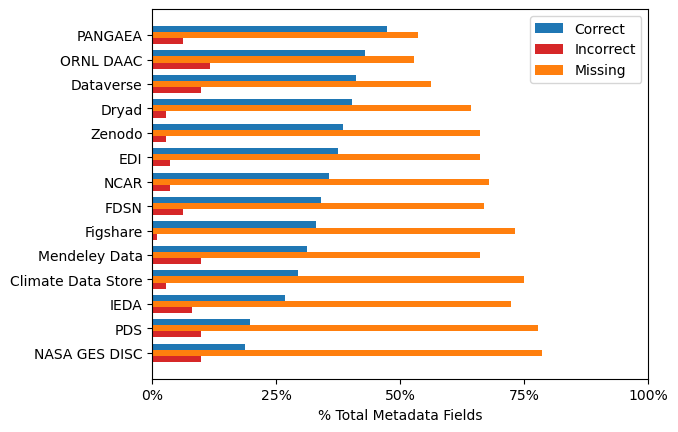

In [699]:
# Horizontal version - no side plot

# Sort values
refman_import_sums_sort = refman_import_sums.sort_values(by=['sum_correct_im'],ascending = True)

# Make graph
fig, ax = plt.subplots()
x = np.arange(14)

y = len(list_of_dfs)*8 # Max value possible for refman_sums for each ref manager

# Percents are df[sum_column]/y*100

offset = 0.25
width = 0.25
ax.barh(x + offset, (refman_import_sums_sort['sum_correct_im']/y*100), width, label = 'Correct', color = 'tab:blue')
ax.barh(x - offset, (refman_import_sums_sort['sum_incorrect_im']/y*100), width, label = 'Incorrect', color = 'tab:red')
ax.barh(x, (refman_import_sums_sort['sum_missing_im']/y*100), width, label = 'Missing', color = 'tab:orange')

# set labels and ticks and axes
ax.set_yticks(x,refman_import_sums_sort['Repository']) # Use Repository column
ax.set_xticks([0,(y/y)/4*100,(y/y)/2*100,3*(y/y)/4*100,y/y*100],ylabels)
ax.set_xlabel('% Total Metadata Fields')
ax.legend(bbox_to_anchor = (1.,1))

plt.show()

# Save fig

fig.savefig((filepath+filename+filename2+'_horiz'+'.png'),dpi=300,bbox_inches='tight')


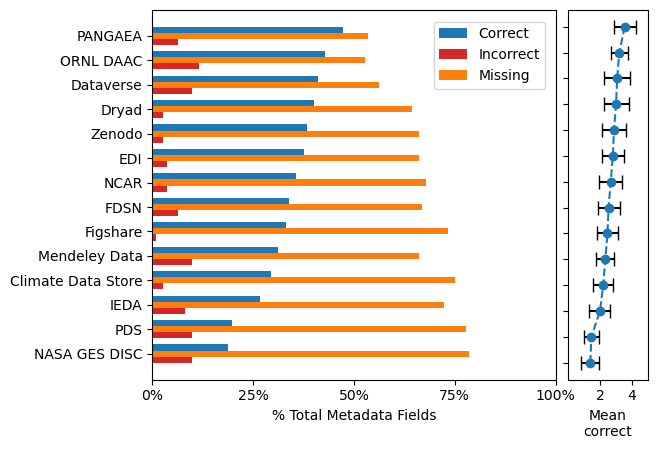

In [700]:
# Horizontal version - plus error side plot

# Sort values
refman_import_sums_sort = refman_import_sums.sort_values(by=['sum_correct_im'],ascending = True)

# Make graph

# data counts
x1 = np.arange(14)
y1 = len(list_of_dfs)*8 # Max value possible for refman_sums for each ref manager

# means and error bars
x2 = np.arange(14)
y2 = np.arange(len(refman_import_sums_sort))

fig, axes = plt.subplots(1, 2, gridspec_kw = {'width_ratios': [5,1]})
offset = 0.25
width = 0.25

# Percents are df[sum_column]/y*100

# Graph ONE
axes[0].barh(x + offset, (refman_import_sums_sort['sum_correct_im']/y1*100), width, label = 'Correct', color = 'tab:blue')
axes[0].barh(x - offset, (refman_import_sums_sort['sum_incorrect_im']/y1*100), width, label = 'Incorrect', color = 'tab:red')
axes[0].barh(x, (refman_import_sums_sort['sum_missing_im']/y1*100), width, label = 'Missing', color = 'tab:orange')

# Graph TWO
axes[1].errorbar(refman_import_sums_sort['mean_correct_by_repo'], y2, xerr = refman_import_sums_sort['sem_correct_by_repo'], ls='--', marker='o', capsize=5, capthick=1, ecolor='black')

# set legend
lines = []
labels = []

for ax in fig.axes:
    Line, Label = ax.get_legend_handles_labels()
    # print (Label)
    lines.extend(Line)
    labels.extend(Label)

# set labels and ticks and axes

# Graph ONE
axes[0].set_yticks(x,refman_import_sums_sort['Repository']) # Use Repository column
axes[0].set_xticks([0,25,50,75,100],ylabels)
axes[0].set_xlabel('% Total Metadata Fields')

# Graph TWO
axes[1].set_yticks(x2, '', rotation = 0)
axes[1].set_xticks([2,4])
axes[1].set_xlim(0,5)
axes[1].set_xlabel('Mean' + '\n' + 'correct')

# set figure legend
fig.legend(lines, labels,bbox_to_anchor=(0.75,0.87))

# set spacing between subplots
plt.subplots_adjust(wspace = 0.05)

plt.show()

# Save fig

fig.savefig((filepath+filename+filename2+'_horiz_error'+'.png'),dpi=300,bbox_inches='tight')


Text(0.5, 0, 'Mean Correct Metadata Fields')

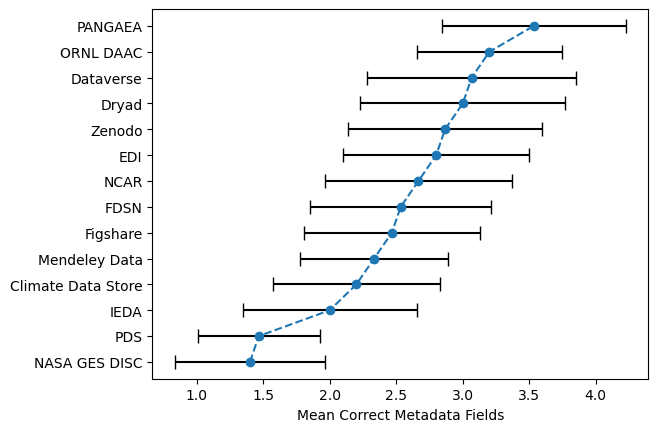

In [701]:
x2 = np.arange(14)
y2 = np.arange(len(refman_import_sums_sort))

fig, ax = plt.subplots()

ax.errorbar(refman_import_sums_sort['mean_correct_by_repo'], y2, xerr = refman_import_sums_sort['sem_correct_by_repo'], ls='--', marker='o', capsize=5, capthick=1, ecolor='black')
ax.set_yticks(x2,refman_import_sums_sort['Repository']) # Use Repository column
ax.set_xlabel('Mean Correct Metadata Fields')

# Most common errors by metadata field

* by import
* by export



In [703]:
# set filename

filename2 = 'errors-by-field'

# list dfs to include should NOT include cross cite, bibtex, bibdesk, or repo_recommended_citation
# list_of_dfs is defined as such in Variables section

# Get df with sum incorrect, missing, and correct for each metadata field by import and export
across_field_sums = sum_across_fields(list_of_dfs)
## Call sum_across_fields(list_of_dfs), as below

# Import
import_fields_count = across_field_sums.loc['import-meta-DOI':'import-meta-version'].sort_values(by = 'sum_correct',ascending = False)

# first sort export
export_fields_count = across_field_sums.loc['export-meta-DOI':'export-meta-version'].sort_values(by = 'sum_correct',ascending = False)

# For both export and import, graph as a stack correct, incorrect, missing for each metadata field

# Common parameters for graphing

x = np.arange(8) # of metadata fields
y = len(list_of_dfs)*len(zotero_plugin['Repository']) # total possible correct fields, len list of dfs * 14 repositories

# ## Start graphing IMPORT


# fig, ax = plt.subplots()

# offset = 0.25
# width = 0.25
# ax.bar(x - offset, (import_fields_count['sum_correct']/y*100), width = width, label = 'Correct', color = 'tab:blue')
# ax.bar(x + offset, (import_fields_count['sum_incorrect']/y*100), width = width, label = 'Incorrect', color = 'tab:red')
# ax.bar(x, (import_fields_count['sum_missing']/y*100), width = width, label = 'Missing', color = 'tab:orange')

# # Get labels and clean them up
# xlabels = import_fields_count.index #labels will be import_sort.index Prev store_data index DOI thru version. Import is 16:24
# xlabels = xlabels.str.replace('-',' ') # replace hyphen
# xlabels = xlabels.str.replace('import','') #don't include 'import'
# xlabels = xlabels.str.replace('repo','Publisher')
# xlabels = xlabels.str.replace('title','Title') 
# xlabels = xlabels.str.replace('meta date','Publication Year') 
# xlabels = xlabels.str.replace('authors','Creator(s)') 
# xlabels = xlabels.str.replace('access date','Access Date') 
# xlabels = xlabels.str.replace('type','Resource Type') 
# xlabels = xlabels.str.replace('version','Version') 
# xlabels = xlabels.str.replace('meta','') #don't include 'meta'



# # set labels and ticks and axes

# ax.set_xticks(x,xlabels, rotation = 75) # Use xlabels or index
# ax.set_yticks([0,(y/y)/4*100,(y/y)/2*100,3*(y/y)/4*100,y/y*100],ylabels)
# ax.set_ylabel('% Total Metadata Fields')
# ax.legend()
# plt.title('Import')

# plt.show()

# # Save fig

# fig.savefig((filepath+filename+filename2+'_import_vert'+'.png'),dpi=300,bbox_inches='tight')

# ## Start graphing EXPORT 

# fig, ax = plt.subplots()

# offset = 0.25
# width = 0.25
# ax.bar(x - offset, (export_fields_count['sum_correct']/y*100), width = width, label = 'Correct', color = 'tab:blue')
# ax.bar(x + offset, (export_fields_count['sum_incorrect']/y*100), width = width, label = 'Incorrect', color = 'tab:red')
# ax.bar(x, (export_fields_count['sum_missing']/y*100), width = width, label = 'Missing', color = 'tab:orange')

# # Get labels and clean them up
# xlabels = export_fields_count.index #labels will be export_sort index Prev store_data index DOI thru version. Export is 7:15
# xlabels = xlabels.str.replace('-',' ') # replace hyphen
# xlabels = xlabels.str.replace('export','') #don't include 'export'
# xlabels = xlabels.str.replace('repo','Publisher')
# xlabels = xlabels.str.replace('title','Title') 
# xlabels = xlabels.str.replace('meta date','Publication Year') 
# xlabels = xlabels.str.replace('authors','Creator(s)') 
# xlabels = xlabels.str.replace('access date','Access Date') 
# xlabels = xlabels.str.replace('type','Resource Type') 
# xlabels = xlabels.str.replace('version','Version') 
# xlabels = xlabels.str.replace('meta','') #don't include 'meta'

# # set labels and ticks and axes
# ax.set_xticks(x,xlabels, rotation = 75) # Use xlabels or index
# ax.set_yticks([0,(y/y)/4*100,(y/y)/2*100,3*(y/y)/4*100,y/y*100],ylabels)
# ax.set_ylabel('% Total Metadata Fields')
# ax.legend()
# plt.title('Export')

# plt.show()

# # Save fig

# fig.savefig((filepath+filename+filename2+'_export_vert'+'.png'),dpi=300,bbox_inches='tight')

# Save CSV for both

across_field_sums.to_csv(str(filepath+filename+filename2+'.csv')) # Save CSV of df with graph data


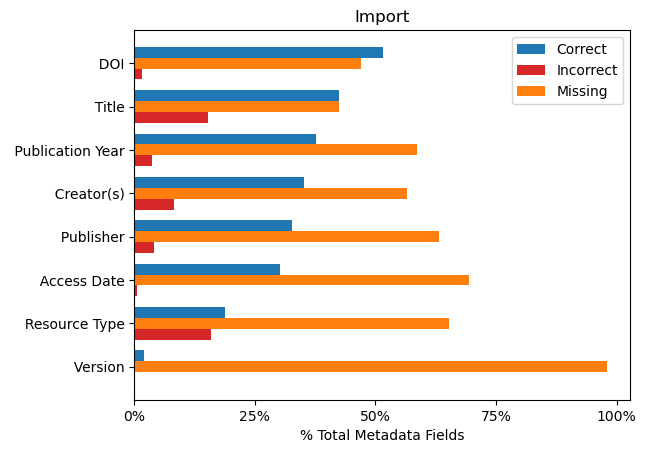

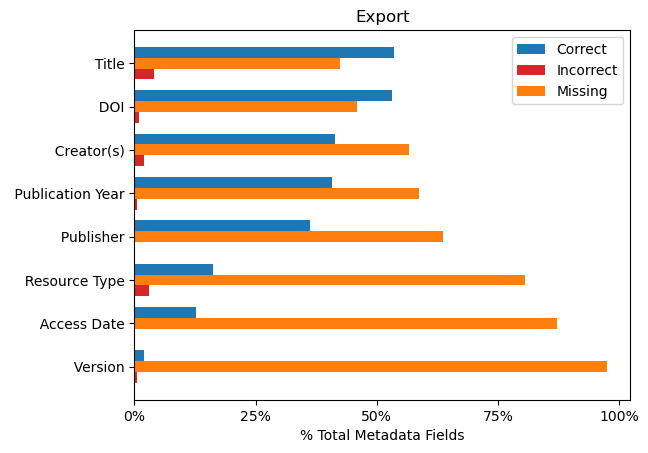

In [704]:
# Horizontal version

# Common parameters for graphing

x = np.arange(8) # of metadata fields
y = len(list_of_dfs)*len(zotero_plugin['Repository']) # total possible correct fields, len list of dfs * 14 repositories


# Sort import
import_fields_count = across_field_sums.loc['import-meta-DOI':'import-meta-version'].sort_values(by = 'sum_correct',ascending = True)

# Sort export
export_fields_count = across_field_sums.loc['export-meta-DOI':'export-meta-version'].sort_values(by = 'sum_correct',ascending = True)

# Start graphing IMPORT 

fig, ax = plt.subplots()



offset = 0.25
width = 0.25
ax.barh(x + offset, import_fields_count['sum_correct']/y*100, width, label = 'Correct', color = 'tab:blue')
ax.barh(x - offset, import_fields_count['sum_incorrect']/y*100, width, label = 'Incorrect', color = 'tab:red')
ax.barh(x, import_fields_count['sum_missing']/y*100, width, label = 'Missing', color = 'tab:orange')

# Get labels and clean them up
xlabels = import_fields_count.index #labels will be import_sort index DOI thru version. Prev used store_data index, import is 16:24
xlabels = xlabels.str.replace('-',' ') # replace hyphen
xlabels = xlabels.str.replace('import','') #don't include 'import'
xlabels = xlabels.str.replace('repo','Publisher')
xlabels = xlabels.str.replace('title','Title') 
xlabels = xlabels.str.replace('meta date','Publication Year') 
xlabels = xlabels.str.replace('authors','Creator(s)') 
xlabels = xlabels.str.replace('access date','Access Date') 
xlabels = xlabels.str.replace('type','Resource Type') 
xlabels = xlabels.str.replace('version','Version') 
xlabels = xlabels.str.replace('meta','') #don't include 'meta'

# set labels and ticks and axes
ax.set_yticks(x,xlabels) # Use xlabels or index
ax.set_xticks([0,(y/y)/4*100,(y/y)/2*100,3*(y/y)/4*100,y/y*100],ylabels)
ax.set_xlabel('% Total Metadata Fields')
ax.legend()
plt.title('Import')

plt.show()

# Save fig

fig.savefig((filepath+filename+filename2+'_import_horiz'+'.png'),dpi=300,bbox_inches='tight')


## Start graphing EXPORT 


fig, ax = plt.subplots()

offset = 0.25
width = 0.25
ax.barh(x + offset, (export_fields_count['sum_correct']/y*100), width, label = 'Correct', color = 'tab:blue')
ax.barh(x - offset, (export_fields_count['sum_incorrect']/y*100), width, label = 'Incorrect', color = 'tab:red')
ax.barh(x, (export_fields_count['sum_missing']/y*100), width, label = 'Missing', color = 'tab:orange')

# Get labels and clean them up
xlabels = export_fields_count.index #labels will be export_sort index DOI thru version. Prev used store_data index, export
xlabels = xlabels.str.replace('-',' ') # replace hyphen
xlabels = xlabels.str.replace('export','') #don't include 'export'
xlabels = xlabels.str.replace('repo','Publisher')
xlabels = xlabels.str.replace('title','Title') 
xlabels = xlabels.str.replace('meta date','Publication Year') 
xlabels = xlabels.str.replace('authors','Creator(s)') 
xlabels = xlabels.str.replace('access date','Access Date') 
xlabels = xlabels.str.replace('type','Resource Type') 
xlabels = xlabels.str.replace('version','Version') 
xlabels = xlabels.str.replace('meta','') #don't include 'meta'

# set labels and ticks and axes
ax.set_yticks(x,xlabels) # Use xlabels or index
ax.set_xticks([0,(y/y)/4*100,(y/y)/2*100,3*(y/y)/4*100,y/y*100],ylabels)
ax.set_xlabel('% Total Metadata Fields')
ax.legend()
plt.title('Export')

plt.show()

# Save fig
fig.savefig((filepath+filename+filename2+'_export_horiz'+'.png'),dpi=300,bbox_inches='tight')
